In [ ]:
### Download CelebA dataset
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
!unzip -qq celeba.zip

--2020-05-23 17:32:03--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.80
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip.2’

celeba.zip.2        100%[===================>]   1.34G  38.8MB/s    in 36s     

2020-05-23 17:32:40 (37.8 MB/s) - ‘celeba.zip.2’ saved [1443490838/1443490838]

replace img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls img_align_celeba | wc -l

202599


In [ ]:
import os
import math
import cv2
import matplotlib.pyplot as plt
import traceback
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

In [ ]:
sample_im_path = 'img_align_celeba/000001.jpg'
im = cv2.imread(sample_im_path)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
im = cv2.resize(im,(128,128))

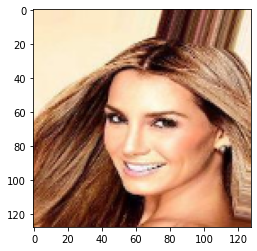

In [ ]:
plt.imshow(im)

### Construct Dataset

In [ ]:
main = 'img_align_celeba'
all_paths = []
for root,dir,files in os.walk(main):
    for f in files:
        all_paths.append(os.path.join(root,f))

### limit images to 5000
all_paths = all_paths[:5000]

In [ ]:
### split images to train and test
train, test = train_test_split(all_paths,test_size=0.2)

In [ ]:
len(train), len(test)

(4000, 1000)

In [ ]:
image_dim = (128,128)

vtrain = []
for f in train:
    try:
        im = cv2.imread(f)
        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        im = cv2.resize(im,image_dim)
        ### given an image of S x S x C, reshape it to S^2 x C, where C equals 3 channels
        vtrain.append(im.reshape(image_dim[0]**2,3).tolist())
    except:
        print(f)
        print(traceback.format_exc())
    pass

In [ ]:
vtrain = np.array(vtrain)

In [ ]:
vtest = []
for f in test:
    try:
        im = cv2.imread(f)
        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        im = cv2.resize(im,image_dim)
        ### given an image of S x S x C, reshape it to S^2 x C, where C equals 3 channels
        vtest.append(im.reshape(image_dim[0]**2,3).tolist())
    except:
        print(f)
        print(traceback.format_exc())
    pass

In [ ]:
vtest = np.array(vtest)

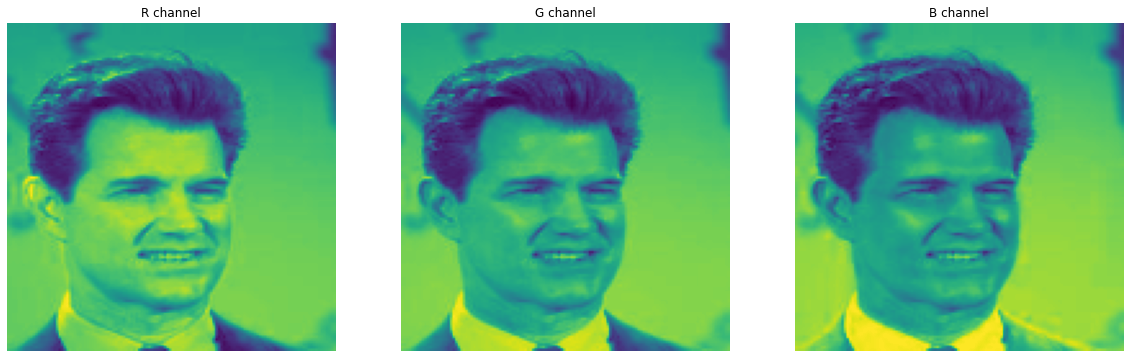

In [ ]:
# R G B channels
rgb_chan = {
    0: 'R channel',
    1: 'G channel',
    2: 'B channel'
}
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(vtrain[0].reshape(128,128,3)[:,:,i])
    plt.title(rgb_chan[i])
    plt.axis('off')

### PCA for Image Reconstruction

In [ ]:
vtrain_tensor = torch.from_numpy(vtrain).type(torch.float32).to(device)
### calculate mean image for each channel
vtrain_mean = vtrain_tensor.mean(dim=0,keepdim=True)
### center images' mean to zero
vtrain_centered = vtrain_tensor - vtrain_mean

In [ ]:
vtrain_centered.shape, vtrain_tensor.shape, vtrain_mean.shape

(torch.Size([4000, 16384, 3]),
 torch.Size([4000, 16384, 3]),
 torch.Size([1, 16384, 3]))

In [ ]:
"""
  desc:
    Retrieve principal axes using SVD, then compute eigenfaces by projecting the images to the principal axes
    Eigenfaces are identical with principal components of the faces
  input:
    mean-centered image tensor, N x S^2
  output:
    eigenfaces, N x S^2
"""
def compute_eigenfaces(centered):

    ### given N x S^2 image vectors, 
    ### compute the covariance matrix of size N x N instead of S^2 x S^2
    cov = torch.matmul(centered,centered.T)

    ### that way, the svd computation will be more efficient
    ### this method will result in only N principal axes, however they still suffice to represent the images
    U,sigma,V = torch.svd(cov)

    ### project the data to the principal axes
    eigenfaces = torch.matmul(V.T,centered)

    ### normalize as unit vectors
    eigenfaces = (eigenfaces/torch.norm(eigenfaces,dim=1).unsqueeze(1))

    return eigenfaces

In [ ]:
### Compute eigenfaces for each channel
r_eigenfaces, g_eigenfaces, b_eigenfaces = compute_eigenfaces(vtrain_centered[:,:,0]), compute_eigenfaces(vtrain_centered[:,:,1]), compute_eigenfaces(vtrain_centered[:,:,2])

In [ ]:
eigenfaces = {
    0: r_eigenfaces,
    1: g_eigenfaces,
    2: b_eigenfaces
}

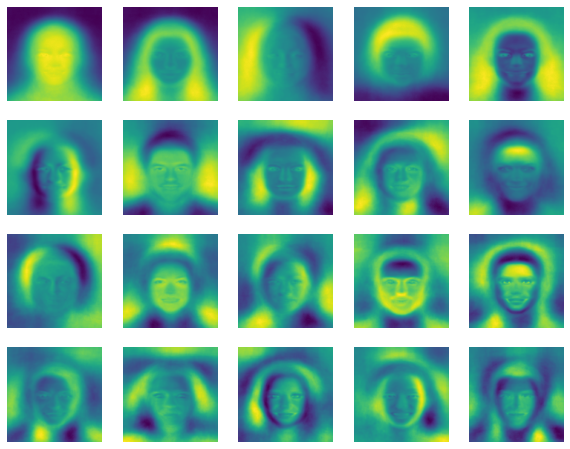

In [ ]:
### visualize eigenfaces
plt.figure(figsize=(10,8))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(r_eigenfaces[i].reshape(128,128).detach().cpu().numpy())
    plt.axis('off')

#### Reconstruct 1-channel Image

In [ ]:
sample_centered_image = vtrain_centered[0,:,0].reshape(1,128*128)

In [ ]:
### The sample image will be able to be represented by linear combination of N eigenfaces
y = torch.matmul(sample_centered_image, r_eigenfaces.T)
recon = torch.matmul(y,r_eigenfaces) + vtrain_mean[:,:,2]

(-0.5, 127.5, 127.5, -0.5)

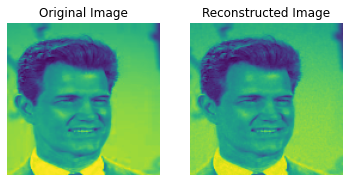

In [ ]:
plt.subplot(1,2,1)
plt.imshow(vtrain_tensor[0,:,2].reshape(128,128).detach().cpu().numpy())
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(recon.reshape(128,128).detach().cpu().numpy())
plt.title('Reconstructed Image')
plt.axis('off')

### The reconstructed result looks identical to the original image despite only N eigenfaces were utilized, instead of S^2 eigenfaces
### N could still be reduced by referring at top K singular values (sigma) that represent the variance of each principal axis

#### Reconstruct RGB images

In [ ]:
### In order to reconstruct the whole image channels, 
rgb_recon = []
for i in range(3):

    ### reconstruct image for each channel
    sample = vtrain_centered[0,:,i].reshape(1,128*128)
    y = torch.matmul(sample, eigenfaces[i].T)
    _recon = torch.matmul(y,eigenfaces[i]) + vtrain_mean[:,:,i]

    ### clamp the reconstructed results between 0 and 255
    rgb_recon.append(_recon.reshape(128,128).clamp(0,255).unsqueeze(2))

### Form the RGB image
rgb = torch.cat((rgb_recon[0],rgb_recon[1],rgb_recon[2]),dim=2)

(-0.5, 127.5, 127.5, -0.5)

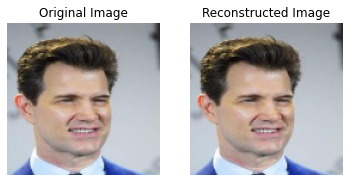

In [ ]:
plt.subplot(1,2,1)
plt.imshow(vtrain_tensor[0,:,:].reshape(128,128,3).detach().cpu().numpy()/255)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(rgb.detach().cpu().numpy()/255)
plt.title('Reconstructed Image')
plt.axis('off')

### Again, the reconstructed image looks identical

### Image Inpainting

In [ ]:
### Test dataset
vtest_tensor = torch.from_numpy(vtest).type(torch.float32).to(device)

### center images' mean to zero by using the train mean
vtest_centered = vtest_tensor - vtrain_mean

In [ ]:
mask = torch.zeros(128,128,3)
mask[60:70,40:60,:] = 1

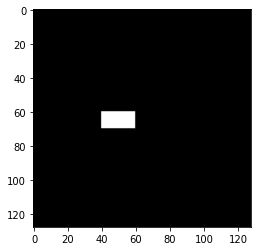

In [ ]:
plt.imshow(mask)

Text(0.5, 1.0, 'Masked Image')

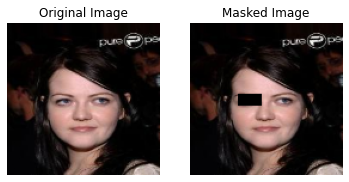

In [ ]:
plt.subplot(1,2,1)
plt.imshow(vtest_tensor[0,:,:].reshape(128,128,3)/255)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(vtest_tensor[0,:,:].reshape(128,128,3)*(1-mask)/255)
plt.axis('off')
plt.title('Masked Image')

In [ ]:
alpha = 0.5
def recursive_pca_reconstruction(image, mask, top_k=0.1, show_iter=True, fast_pca=True):
    recon = image.copy()
    col_per_row = 5
    rows = math.ceil(num_iter / col_per_row)
        
    Y_prev = 0
    Y_diff = 1e6
    i = 0
    
    recons = []
    diffs = []
    while(True):
        curr_row = math.floor(i/col_per_row) + 1
        
        Y_k_masked2 = np.matmul(recon.reshape(1,12000) - mean_vtrain.T, V[:k].T)
        
        if fast_pca and Y_diff != 1e6:
                Y_k_masked2 = Y_k_masked2 + alpha * (Y_k_masked2 - Y_prev)
            
        result = (np.matmul(Y_k_masked2 ,V[:k]) + mean_vtrain.T).reshape(120,100)
        recon = (recon * mask) + result * (1-mask)

        Y_diff = round(np.max(np.abs(Y_prev - Y_k_masked2)),2)
        
        if Y_diff < 0.05:
            break
        
        recons.append(recon)
        diffs.append(Y_diff)
        
        Y_prev = Y_k_masked2
        i = i+1
    
    if not show_iter:
        plt.title('iteration: {}, coeff diff: {}'.format(i,Y_diff))
        plt.imshow(recon)
        plt.axis('off')
    else:
        plt.figure(figsize=(20,80))
        for index,item in enumerate(recons):
            plt.subplot(len(recons),col_per_row,index+1)
            plt.title('iteration: {}, coeff diff: {}'.format(index,diffs[index]))
            plt.imshow(item)
            plt.axis('off')
        plt.tight_layout()

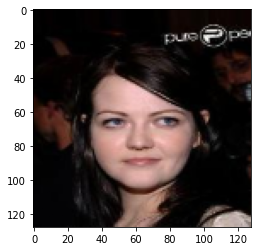

In [ ]:
plt.imshow(vtest_tensor[0,:,:].reshape(128,128,3)/255)

In [ ]:
vtest_tensor.shape

torch.Size([1000, 16384, 3])

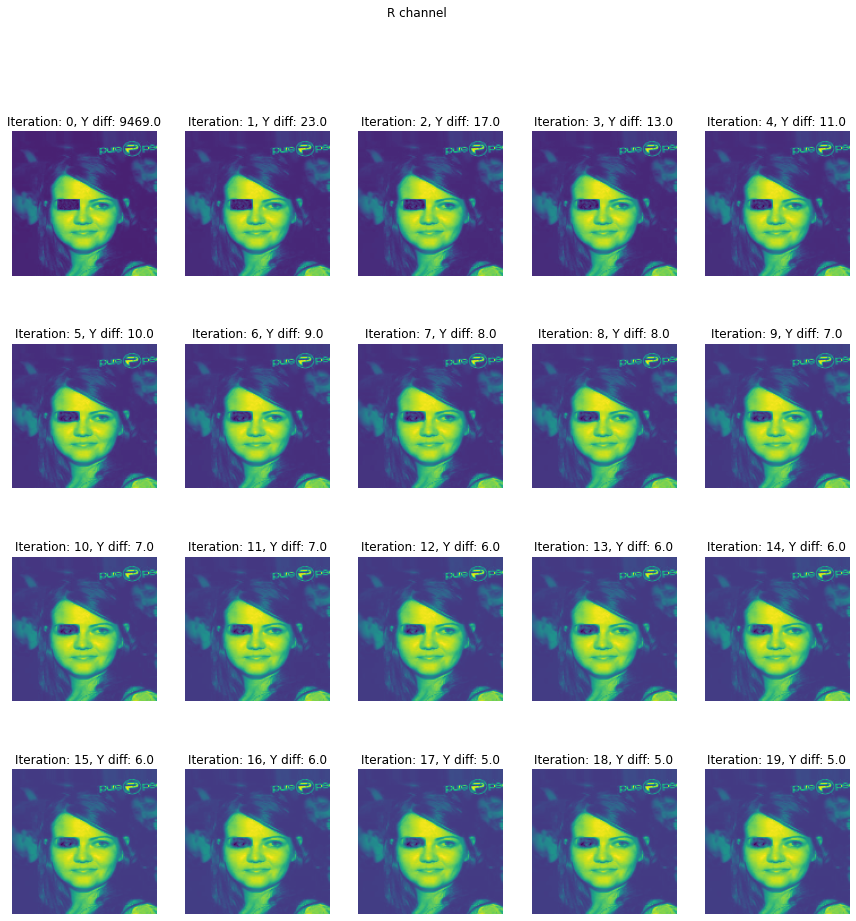

In [ ]:
num_iter = 20
col_per_row = 5
rows = math.ceil(num_iter / col_per_row)

rgb_recon = []

for c in range(1):
  masked = vtest_tensor[0,:,c].reshape(128,128)*(1-mask[:,:,0])
  recon = masked

  plt.figure(figsize=(15,15))
  plt.suptitle(rgb_chan[c])
  y_prev = 1000

  for i in range(num_iter):
    curr_row = math.floor(i/col_per_row) + 1
    plt.subplot(rows,col_per_row,i+1)

    y = torch.matmul(recon.reshape(1,128**2) - vtrain_mean[:,:,c], eigenfaces[c].T)
    result = (torch.matmul(y,eigenfaces[c]) + vtrain_mean[:,:,c]).reshape(128,128)

    recon = (result * mask[:,:,0]) + recon * (1-mask[:,:,0])
        
    y_diff = torch.round(torch.max(torch.abs(y_prev - y))).item()
    
    plt.title('Iteration: {}, Y diff: {}'.format(i,y_diff))
    plt.imshow(recon)
    plt.axis('off')
    
    y_prev = y

  rgb_recon.append(recon)

In [ ]:
masked = vtrain_tensor[0,:,0].reshape(128,128)*(1-mask[:,:,0])

In [ ]:
norm_masked = masked.reshape(1,128*128) - vtrain_mean[:,:,0]

In [ ]:
y = torch.matmul(norm_masked, eigenfaces[0].T)

In [ ]:
vtrain_mean[:,:,0].max()

tensor(213.2668)

In [ ]:
eigenfaces[0].shape

torch.Size([4000, 16384])

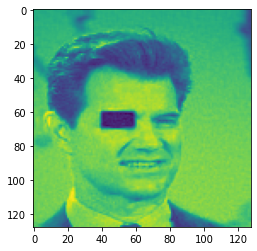

In [ ]:
plt.imshow((torch.matmul(y,eigenfaces[0])).reshape(128,128))

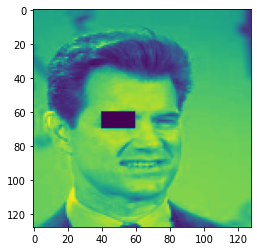

In [ ]:
plt.imshow(masked/255)

In [ ]:
test = torch.cat((rgb_recon[0].unsqueeze(2),rgb_recon[1].unsqueeze(2),rgb_recon[2].unsqueeze(2)),dim=2)

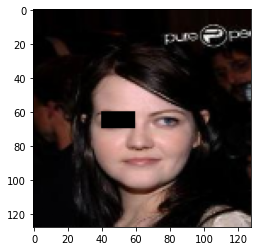

In [ ]:
plt.imshow(masked/255)

In [ ]:
### In order to reconstruct the whole image channels, 
rgb_recon = []
for i in range(3):

  ### reconstruct image for each channel
  sample = vtrain_centered[0,:,i].reshape(1,128*128)
  y = torch.matmul(sample, eigenfaces[i].T)
  _recon = torch.matmul(y,eigenfaces[i]) + vtrain_mean[:,:,i]

  ### clamp the reconstructed results between 0 and 255
  rgb_recon.append(_recon.reshape(128,128).clamp(0,255).unsqueeze(2))

### Form the RGB image
rgb = torch.cat((rgb_recon[0],rgb_recon[1],rgb_recon[2]),dim=2)

In [ ]:
vtrain_mean[:,:,0].shape

torch.Size([1, 16384])

In [ ]:
np.max(np.array([1,2,3]))

3

In [ ]:
eigenfaces[0].shape

torch.Size([4000, 16384])

In [ ]:
sample.shape

torch.Size([1, 16384])

In [ ]:
y.shape

torch.Size([1, 4000])